Data Analysis of the data used

In [1]:
from src.recommender import parse_json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [39]:
reviews = parse_json("./data/australian_user_reviews.json")
user_items = parse_json("./data/australian_users_items.json")
steam_games = parse_json("./data/steam_games.json")

25799it [00:02, 9323.79it/s] 


Reading 25799 rows.


88310it [02:39, 553.93it/s] 


Reading 88310 rows.


32135it [00:03, 10054.85it/s]


Reading 32135 rows.


Amount of games per user

                 user_id  items_count
44154             dkimmm            0
50723  76561198042745849            0
50716  76561198042725721            0
50713  76561198042712452            0
50709  76561198042711240            0
...                  ...          ...
5995      mayshowganmore         5027
6022              piepai         6132
1104              chidvd         6410
19055       thugnificent         6700
3708             phrostb         7762

[88310 rows x 2 columns]


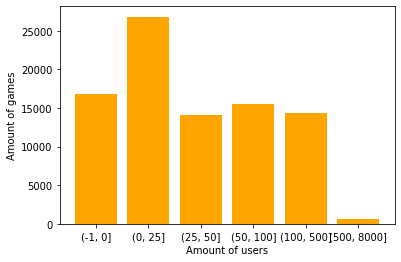

In [68]:
buckets = [-1, 0, 25, 50, 100, 500, 8000]
user_item_count = user_items[["user_id", "items_count"]].copy()
user_item_count = user_item_count.sort_values("items_count")
print(user_item_count)
user_item_count["items_count"] = pd.cut(user_item_count["items_count"], buckets).apply(str)

user_item_count = user_item_count.groupby("items_count").count()

x = user_item_count["user_id"].index.to_numpy()
y = user_item_count["user_id"].to_numpy()   

plt.bar(x, y, color="orange")
plt.xlabel("Amount of users")
plt.ylabel("Amount of games")
plt.show()

Amount of reviews per user

                 user_id  reviews_count
25001  76561198102423654              0
24911  76561198100396147              0
7583   76561198079215291              0
9894   76561198061996985              0
21386  76561198063489150              0
...                  ...            ...
16268  76561198080345478             10
2848          TrackFight             10
19297         kiniston69             10
2911          Blackboy72             10
7071       SambaWarKiddo             10

[25799 rows x 2 columns]


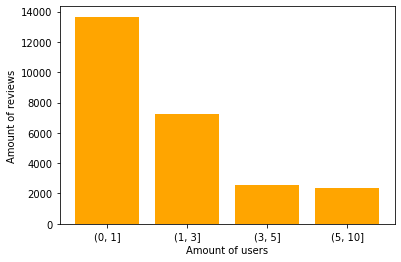

In [70]:
bins = [0, 1, 3, 5, 10]
user_review_count = reviews[["user_id", "reviews"]].copy()
user_review_count["reviews_count"] = user_review_count["reviews"].apply(len)
user_review_count = user_review_count.sort_values("reviews_count")
print(user_review_count[["user_id", "reviews_count"]])
user_review_count["reviews_count"] = pd.cut(user_review_count["reviews_count"], bins).apply(str)

user_review_count = user_review_count.groupby("reviews_count").count()

x = user_review_count["user_id"].index.to_numpy()
y = user_review_count["user_id"].to_numpy()   

plt.bar(x, y, color="orange")
plt.xlabel("Amount of users")
plt.ylabel("Amount of reviews")
plt.show()

Popularity of games

In [44]:
game_popularity = user_items[["user_id", "items"]]
game_popularity = game_popularity.explode("items", ignore_index=True)
game_popularity.dropna(inplace=True)
game_popularity["items"] = game_popularity["items"].apply(lambda x: x["item_name"])
game_popularity = game_popularity.groupby("items").count()
print(game_popularity.sort_values("user_id"))

                                  user_id
items                                    
Fire Farm VR                            1
PD Howler 10                            1
PD Howler 9.6                           1
Crazy Machines 1.5                      1
PRINCIPIA: Master of Science            1
...                                   ...
Left 4 Dead 2                       37044
Unturned                            38682
Garry's Mod                         43301
Counter-Strike: Global Offensive    43776
Dota 2 Test                         49571

[10947 rows x 1 columns]


In [40]:
print(steam_games.shape)

(32135, 16)


Tags from games in our data

In [62]:
game_tags = steam_games[["genres", "tags", "specs"]].copy()

game_tags["genres"] = game_tags["genres"].fillna("").apply(set)
genre_set = set()
for s in game_tags.genres.values:
    genre_set.update(s)
game_tags["tags"] = game_tags["tags"].fillna("").apply(set)
tags_set = set()
for s in game_tags.tags.values:
    tags_set.update(s)
game_tags["specs"] = game_tags["specs"].fillna("").apply(set)
specs_set = set()
for s in game_tags.specs.values:
    specs_set.update(s)

all_tags = set.union(genre_set, tags_set, specs_set)
print(genre_set, "\n")
print(tags_set, "\n")
print(specs_set, "\n")
print(all_tags, "\n")

{'Web Publishing', 'Photo Editing', 'Casual', 'Design &amp; Illustration', 'Indie', 'Massively Multiplayer', 'Sports', 'Software Training', 'Audio Production', 'Education', 'Accounting', 'Simulation', 'Racing', 'Animation &amp; Modeling', 'Action', 'Free to Play', 'Strategy', 'Adventure', 'Early Access', 'Video Production', 'RPG', 'Utilities'} 

{'Football', 'Real Time Tactics', 'Rome', 'Investigation', 'Gothic', 'Conversation', 'Medieval', 'Turn-Based Combat', 'Co-op', 'Sandbox', 'Puzzle-Platformer', 'Free to Play', 'Space', 'Political', 'Cinematic', 'MOBA', 'Trading', 'Platformer', 'Voice Control', 'Management', 'Magic', 'Drama', 'Fantasy', 'Local Co-Op', 'Arena Shooter', 'Flight', 'Replay Value', 'Great Soundtrack', 'CRPG', 'Movie', 'Transhumanism', 'Mining', 'Class-Based', 'Turn-Based', 'Funny', 'Story Rich', 'Cute', 'Hex Grid', 'Gambling', 'Dark Fantasy', '4 Player Local', 'Short', 'Turn-Based Tactics', 'Horses', 'Foreign', 'Parody', 'Character Customization', 'Sports', "Beat 'em 

In [65]:
print(len(set.union(tags_set, genre_set)))

342
